In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import random
import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (22.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

from livelossplot import PlotLosses
from time import sleep

In [2]:
def create_dataset_from_scots(controller_filename, deterministic = False):
    f = open(controller_filename, "r")
    lines = []
    for line in f:
        if '#MATRIX:DATA\n' in line:                
            for line in f: # now you are at the lines you want
                # skip the #BEGIN 
                # read the state-actions
                lines = f.readlines()
    del lines[-1] # delete #END
    # take the state as the train dataset
    list_train_dataset = []
    for x in lines:
        list_train_dataset.append(x.split(' ')[0])
    # convert to the numpy array with float32 data type
    train_dataset = np.asarray(list_train_dataset)
    train_dataset = train_dataset.astype(np.float32)
    # take action/label pair of the state 
    # take the action(s) [column 1:-1] / the rest of the integer except the state
    list_train_label = []
    for x in lines:
        if deterministic == False:
            list_train_label.append(x.strip().split()[1:])
        else:
            list_train_label.append(x.strip().split()[1])
    # convert to numpy array, note that the result is still not in one hot encoding format
    train_label = np.asarray(list_train_label)
    # define number of samples
    num_samples = train_label.shape[0]
    if deterministic == False:
        # select to use ND or D case here
        # create now array to be filled by the encoded label
        train_label_hot = np.zeros([num_samples,2], dtype=np.float32)
        # encode label to one hot encoding format
        for i in range(num_samples):
            if train_label[i] == ['0']:
                train_label_hot[i] = [1, 0]
            elif train_label[i] == ['1']:
                train_label_hot[i] = [0, 1]
            elif train_label[i] == ['0','1']:
                train_label_hot[i] = [1, 1]
    else:
        train_label_hot = train_label[:, None].astype(np.uint8)


In [3]:
det = False

In [4]:
# parse the controller file
f = open('../COTONN/dcdc_small/controller.scs', "r")

lines = []

for line in f:
    if '#MATRIX:DATA\n' in line:                
        for line in f: # now you are at the lines you want
            # skip the #BEGIN 
            # read the state-actions
            lines = f.readlines()
            
del lines[-1]

# take the state as the train dataset
ltrain_dataset = []
for x in lines:
    ltrain_dataset.append(x.split(' ')[0])
# del ltrain_dataset[-1] # delete the string #END at the end of the file 

# convert to the numpy array with float32 data type
train_dataset = np.asarray(ltrain_dataset)
train_dataset = train_dataset.astype(np.float32)

upper_limit = train_dataset.shape[0]
num_samples = upper_limit

# take action/label pair of the state 
# take the action(s) [column 1:-1] / the rest of the integer except the state
ltrain_label = []
for x in lines:
    if det == False:
        ltrain_label.append(x.strip().split()[1:])
    else:
        ltrain_label.append(x.strip().split()[1])
# del ltrain_label[-1] # delete the string #END at the end of the file  

# convert to numpy array, note that the result is still not in one hot encoding format
train_label = np.asarray(ltrain_label)

# define number of samples
num_samples = train_dataset.shape[0]

if det == False:
    # select to use ND or D case here
    # create now array to be filled by the encoded label
    train_label_int = [[int(i) for i in l] for l in ltrain_label]
    action_setlist = sorted(set(x for l in train_label_int for x in l))
    num_label = len(action_setlist)
    train_label_hot = np.zeros([num_samples, num_label], dtype=np.float32)
    for i,actions in enumerate(train_label_int):
        for action in actions:
            train_label_hot[i, action_setlist.index(action)] = 1
else:
    train_label_hot = train_label[:, None].astype(np.uint8)

In [5]:
len(max(ltrain_label,key=len))

2

In [6]:
train_label_hot.shape

(8677, 2)

In [7]:
upper_limit = train_dataset.shape[0]
upper_limit

8677

In [8]:
train_dataset_dim = train_dataset[:, None]
# slice the samples
train_sliced = train_dataset_dim[:upper_limit]
# change it to init
train_sliced_int = train_sliced.astype(np.uint32)
# split to 4 bytes
tsi8_unordered = train_sliced_int.view(np.uint8)
# little endian format
tsi8 = np.flip(tsi8_unordered,1)
# unpack
toy_vehicle_input_unreduced = np.unpackbits(tsi8).reshape(-1,32)

# get index of MSB
msb = len(bin(int(np.max(train_dataset_dim))))-2
# get total bit
total_bit = toy_vehicle_input_unreduced.shape[1]
# reduce to the minimal binary representation
toy_vehicle_input = toy_vehicle_input_unreduced[:, np.arange(total_bit-msb,total_bit)]

num_label = train_label_hot.shape[1]

input_size = toy_vehicle_input.shape[1]

train_dataset_reform = toy_vehicle_input

In [9]:
train_dataset_reform.shape

(8677, 14)

In [10]:
train_label_hot.shape

(8677, 2)

In [11]:
def accuracy_softmax(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_multilabel(predictions, labels):
    return (100.0 * np.mean(predictions == labels))

def accuracy_multilabel_softmax(predictions, labels):
    predictions_soft = np.zeros_like(predictions)
    predictions_soft[np.arange(len(predictions)), predictions.argmax(1)] = 1
    return (100.0*np.mean(labels[np.arange(len(labels)), predictions_soft.argmax(1)]))


In [89]:
tf.reset_default_graph()

batch_size = 1024 # num_samples # (num_samples//20) # 113*6 # num_samples
num_batches = np.ceil(num_samples/batch_size)
state_size = 1
input_LSTM_size = 1
backprop_length = train_dataset_reform.shape[1]

In [90]:
print(batch_size)
print(num_batches)
print(backprop_length)

1024
9.0
14


In [91]:
input_size

14

In [92]:
num_layers = 100

In [93]:
# with tf.device('/device:GPU:0'):
# tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
# tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_label))
tf_train_dataset = tf.placeholder(tf.float32, shape=(None, input_size))
tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_label))
dropout_prob = tf.placeholder(tf.float32)

# cell_state = tf.placeholder(tf.float32, [None, state_size])
# hidden_state = tf.placeholder(tf.float32, [None, state_size])
# init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)
init_state = tf.placeholder(tf.float32, [num_layers, 2, None, state_size])
state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.nn.rnn_cell.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

Wout = tf.Variable(np.random.rand(backprop_length, num_label),dtype=tf.float32)
bout = tf.Variable(np.zeros((1,num_label)), dtype=tf.float32)

inputs_series = tf.split(tf_train_dataset, input_size, 1)

from tensorflow.contrib import rnn 
# cell = rnn.BasicLSTMCell(state_size)
# states_series, current_state = rnn.static_rnn(cell, inputs_series, init_state)

cell = tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True)
cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
states_series, current_state = tf.nn.static_rnn(cell, inputs_series, initial_state=rnn_tuple_state)

states_series_reshape = tf.reshape(tf.stack(states_series, 1), [-1, backprop_length])

In [94]:
logits = tf.matmul(states_series_reshape, Wout) + bout
predictions = tf.nn.softmax(logits)
losses = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits,labels = tf_train_labels)
total_loss = tf.reduce_mean(losses)
# train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)
train_step = tf.train.AdamOptimizer(0.0015).minimize(total_loss)

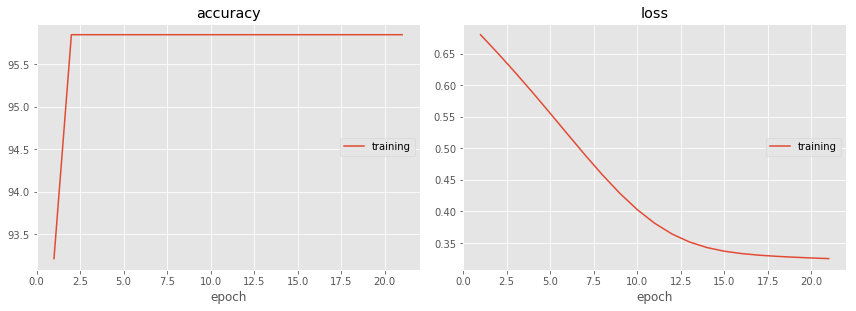

Epoch:    21, Loss: 0.324990, Accuracy: 95.85%


KeyboardInterrupt: 

In [95]:
loss_history = []
acc_history = []
liveplot = PlotLosses()

acc = 0
acc_cum = 0
acc_temp = 0
epoch_idx = 0
loss_disp_true = False
loss_avg = 0.0
old_loss_avg = 0.0
loss_cum = 0.0
need_one_more_iteration = True

early_stop_loss_counter = 0
not_early_stop = True

with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    while (((acc < 100) or need_one_more_iteration) and not_early_stop):
        
        if (acc >= 100):
            need_one_more_iteration = False
        else:
            need_one_more_iteration = True
            
        epoch_idx += 1
        acc_cum = 0
        
        for step in range(int(num_batches)):
            offset = (step * batch_size)
            if num_samples > offset + batch_size:
                batch_limit = offset + batch_size
            else:
                batch_limit = num_samples
                loss_disp_true = True

            # _current_cell_state = (np.zeros((batch_limit-offset, state_size)))
            # _current_hidden_state = (np.zeros((batch_limit-offset, state_size)))
            
            _current_state = np.zeros((num_layers, 2, batch_limit-offset, state_size))


            batch_data = train_dataset_reform[offset:(batch_limit), :]
            batch_labels = train_label_hot[offset:(batch_limit), :]

            l , _train_step, _current_state, _predictions, = session.run(
                [total_loss, train_step, current_state, predictions],
                feed_dict={
                    tf_train_dataset: batch_data,
                    tf_train_labels: batch_labels,
                    init_state : _current_state
                })
            
            # cell_state: _current_cell_state,
            # hidden_state: _current_hidden_state
            # writer.add_summary(added_summary)
            acc_temp =  accuracy_multilabel_softmax(_predictions, batch_labels)
            acc_cum += acc_temp
            acc = acc_cum/(step+1)
            loss_cum += l
            if loss_disp_true:
                loss_disp_true = False
                loss_avg = loss_cum/num_batches
                loss_cum = 0
                loss_history.append(loss_avg)
                acc_history.append(acc)
                liveplot.update({
                    'accuracy': acc,
                    'loss': loss_avg,
                })
                liveplot.draw()
                print("Epoch:{0:6d}, Loss: {1:8.6f}, Accuracy:{2:6.2f}%".format(epoch_idx, loss_avg, acc))
                
                if loss_avg == old_loss_avg:
                    print('stagnan')
                    early_stop_loss_counter += 1
                    if early_stop_loss_counter == 100:
                        not_early_stop = False    
                old_loss_avg = loss_avg
               
    # Do for the test batch
    acc = 0
    acc_cum = 0
    for step in range(int(num_batches)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) #  % (train_label_hot.shape[0] - batch_size)
        
        if num_samples > offset + batch_size:
            batch_limit = offset + batch_size
        else:
            batch_limit = num_samples
            loss_disp_true = True

        # _current_cell_state = (np.zeros((batch_limit-offset, state_size)))
        # _current_hidden_state = (np.zeros((batch_limit-offset, state_size)))
        _current_state = np.zeros((num_layers, 2, batch_limit-offset, state_size))
        # offset = np.random.randint(num_samples - batch_size , size = 1)[0]
        # Generate a minibatch.
        batch_data = train_dataset_reform[offset:(batch_limit), :]
        batch_labels = train_label_hot[offset:(batch_limit), :]

        l, _current_state, _predictions, = session.run(
            [total_loss, current_state, predictions],
            feed_dict={
                tf_train_dataset: batch_data,
                tf_train_labels: batch_labels,
                init_state : _current_state
            })

        # writer.add_summary(added_summary)
        acc_temp =  accuracy_multilabel_softmax(_predictions, batch_labels)
        acc_cum += acc_temp
        acc = acc_cum/(step+1)
        
        print("batch_limit {0:6d} Training Acc: {1:8.2f} {2:8.2f} {3:8.2f}%".format(batch_limit, acc_temp, acc_cum, acc))

    print(acc)

In [43]:
acc_history[-10:]

[99.98914930555556,
 99.98914930555556,
 99.98914930555556,
 99.98914930555556,
 99.98914930555556,
 99.98914930555556,
 99.98914930555556,
 99.98914930555556,
 100.0,
 100.0]

In [44]:
hidden = 'LSTM'+str(state_size)

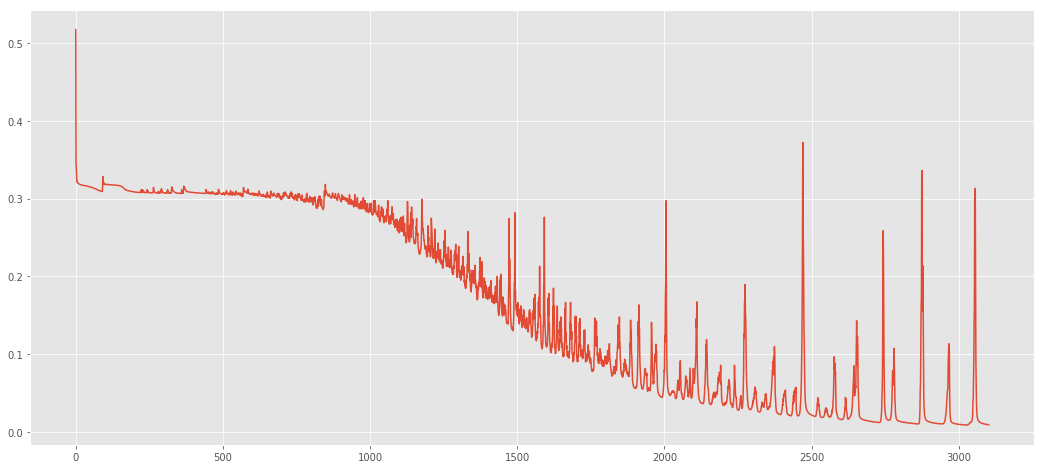

<Figure size 1296x576 with 0 Axes>

In [45]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.style.use('ggplot')
plt.plot(loss_history)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig(f.name[:-4]+hidden+'_loss_nd.png', dpi = 200)

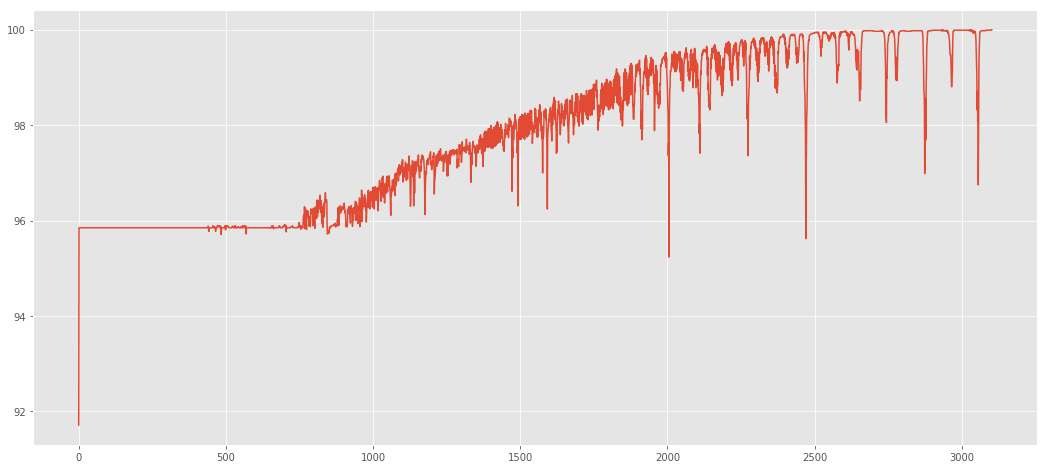

<Figure size 1296x576 with 0 Axes>

In [46]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.style.use('ggplot')
plt.plot(acc_history)
fig = plt.gcf()
plt.show()
plt.draw()
fig.savefig(f.name[:-4]+hidden+'_acc_nd.png', dpi = 200)

In [47]:
lh_array = np.array(loss_history)[:, np.newaxis]

In [48]:
ah_array = np.array(acc_history)[:, np.newaxis]

In [49]:
ei_array = np.arange(epoch_idx, dtype=object)[:, np.newaxis]

In [50]:
training_history = np.concatenate((ei_array, lh_array, ah_array), axis = 1)

In [55]:
np.savetxt(f.name[:-4]+hidden+'_nd.csv', training_history, delimiter=",", fmt = "%d,""%2.6f,""%2.2f")